In [2]:
from modulos import ann, eda, ml_func
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

2025-08-13 18:41:21.599794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755124881.611660 1757145 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755124881.615271 1757145 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755124881.625136 1757145 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755124881.625146 1757145 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755124881.625148 1757145 computation_placer.cc:177] computation placer alr

In [3]:
df = eda.data_processing('Cotas extraidas', '1985-01-01', '2024-12-31', ['dados_diarios_estacao_14300000.csv'])
df_mensal = df.resample('MS').mean()
df_mensal

,14300000
Data,
1985-01-01,508.354839
1985-02-01,395.714286
1985-03-01,446.870968
1985-04-01,398.733333
1985-05-01,612.387097
...,...
2024-08-01,501.806452
2024-09-01,424.633333
2024-10-01,433.096774


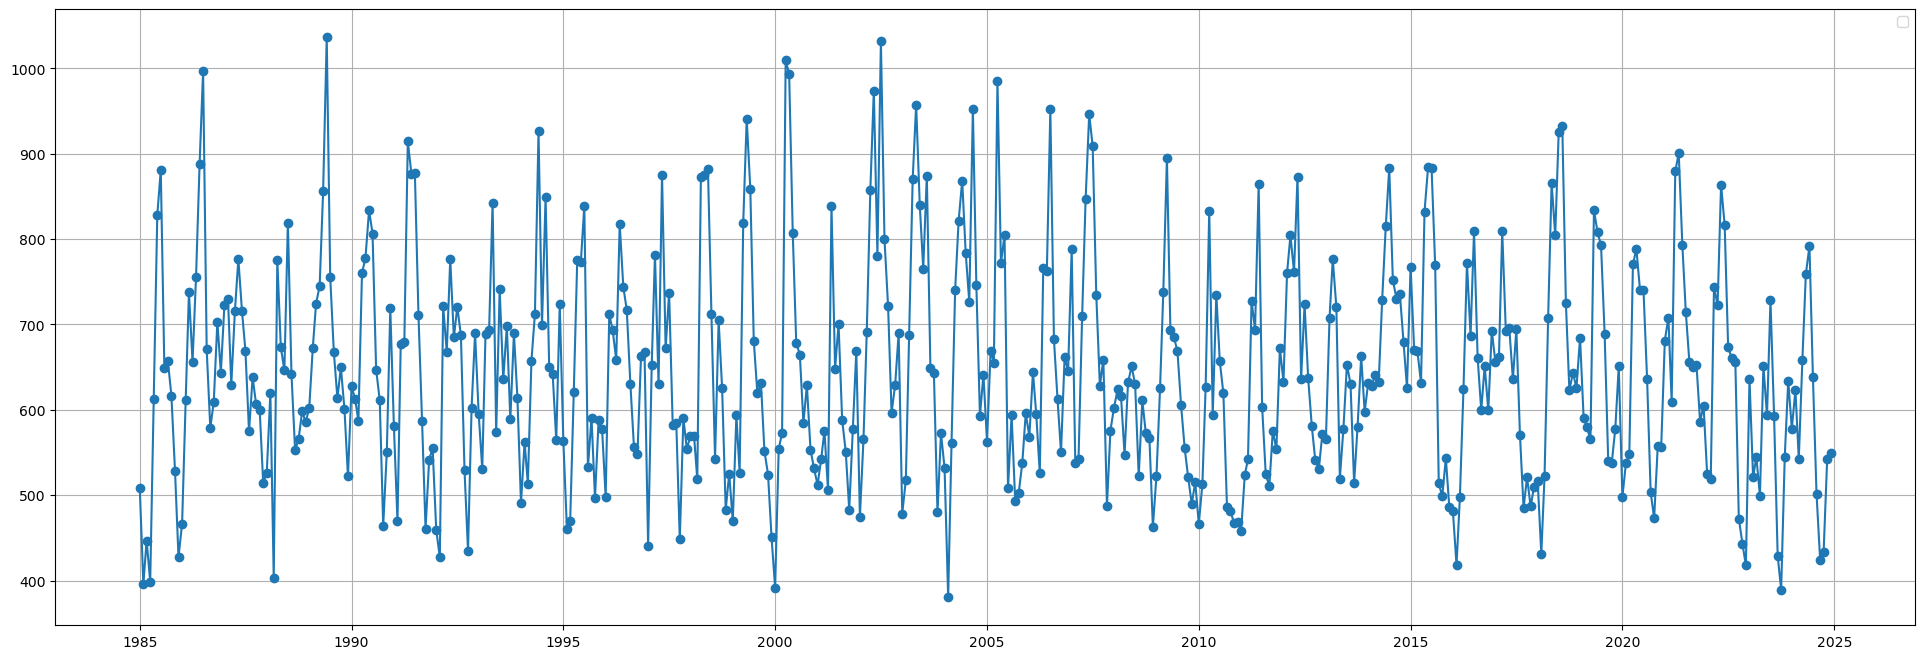

In [7]:
plt.figure(figsize=(24, 8))
plt.plot(df_mensal['14300000'], marker='o')
plt.legend()
plt.grid(True)
plt.show()

### Teste ML 1

In [36]:
treino = df_mensal['1985-01-01':'2014-12-01']
teste = df_mensal['2015-01-01':]

janela = 3
steps = 1
X, y = ml_func.create_multi_step_dataset(df_mensal['14300000']['1985-01-01':].values, janela, steps)

x_train1 = X[:treino.shape[0]-janela]
y_train1 = y[:treino.shape[0]-janela]

x_test1 = X[treino.shape[0]-janela:]
y_test1 = y[treino.shape[0]-janela:]

x_scale1 = MinMaxScaler()
x_train1 = x_scale1.fit_transform(x_train1)
x_test1 = x_scale1.transform(x_test1)

y_scale1 = MinMaxScaler()
y_train1 = y_scale1.fit_transform(y_train1)

In [37]:
lstm = ann.build_model_lstm(30, janela, steps)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lstm.fit(x_train1, y_train1, epochs=250, callbacks=early_stop)

Epoch 1/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2184 - mean_absolute_error: 0.4198  
Epoch 2/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1377 - mean_absolute_error: 0.3196 
Epoch 3/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0832 - mean_absolute_error: 0.2297 
Epoch 4/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0684 - mean_absolute_error: 0.1955 
Epoch 5/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0395 - mean_absolute_error: 0.1497 
Epoch 6/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0402 - mean_absolute_error: 0.1619 
Epoch 7/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0353 - mean_absolute_error: 0.1507 
Epoch 8/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0346 - mean_absolute_error: 0.1475 
Epoch 9/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380 - mean_absolute_error: 0.1561 
Epoch 10/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0352 - mean_absolute_error: 0.1472 
Epoch 11/250
12/12 ━━━━━━━━━

In [38]:
pred1 = lstm.predict(x_test1)
pred1_inv = y_scale1.inverse_transform(pred1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


R² = 0.4386


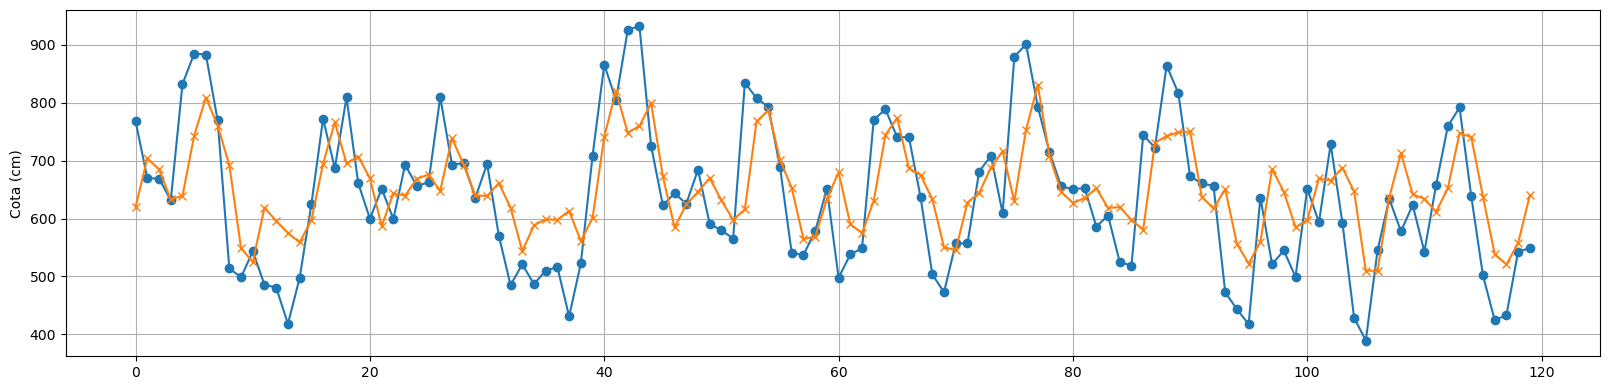

In [39]:
print(f"R² = {r2_score(y_test1, pred1_inv):.4f}")

plt.figure(figsize=(16, 4))
plt.plot(y_test1, marker='o', linestyle='-', label='Observado')
plt.plot(pred1_inv, marker='x', linestyle='-', label='Predito')
plt.tight_layout()
plt.ylabel('Cota (cm)')
plt.grid(True)
plt.show()

### Teste ML 2

In [4]:
el_nino_mensal3 = pd.read_csv('El Nino - indices/nino3_index.txt',
                             sep=r'\s+',
                             comment='#',
                             names=['Data', 'El Nino 3'])

el_nino_mensal34 = pd.read_csv('El Nino - indices/nino34_index.txt',
                             sep=r'\s+',
                             comment='#',
                             names=['Data', 'El Nino 3.4'])

el_nino_mensal3['Data'] = pd.to_datetime(el_nino_mensal3['Data'])
el_nino_mensal3.index = el_nino_mensal3['Data']
el_nino_mensal3.drop(columns=['Data'], inplace=True)

el_nino_mensal34['Data'] = pd.to_datetime(el_nino_mensal34['Data'])
el_nino_mensal34.index = el_nino_mensal34['Data']
el_nino_mensal34.drop(columns=['Data'], inplace=True)

df = el_nino_mensal3['1985-01-01':'2024-12-01'].copy()
df['El Nino 3.4'] = el_nino_mensal34['El Nino 3.4']['1985-01-01':'2024-12-01']
df['14300000'] = df_mensal['14300000']
df

,El Nino 3,El Nino 3.4,14300000
Data,,,
1985-01-01,-2.992533,-2.679568,508.354839
1985-02-01,-1.421772,-1.937945,395.714286
1985-03-01,0.363471,-0.971542,446.870968
1985-04-01,1.460344,-0.206249,398.733333
1985-05-01,0.984154,0.036957,612.387097
...,...,...,...
2024-08-01,-0.288915,0.198009,501.806452
2024-09-01,-0.767842,-0.052544,424.633333
2024-10-01,-1.414412,-0.293522,433.096774


In [5]:
tgt = '14300000'

decomp = seasonal_decompose(df['14300000'], model='additive', period=12)
deseason = df[tgt] - decomp.seasonal

for c in df.columns:
    if c == tgt:
        continue

    best_lag = None
    d_best_lag = None
    min_corr = np.inf
    d_min_corr = np.inf

    for i in range(0, 10):
        corr = df[tgt].corr(df[c].shift(i), method='spearman')
        d_corr = deseason.corr(df[c].shift(i), method='spearman')

        if corr < min_corr:
            min_corr = corr
            best_lag = i
        
        if d_corr < d_min_corr:
            d_min_corr = d_corr
            d_best_lag = i
    
    print(f"Coluna: {c}")
    print(f"Melhor lag = {best_lag}; Correlação = {min_corr:.4f}")
    print(f"D Melhor lag = {d_best_lag}; Correlação = {d_min_corr:.4f}\n")

Coluna: El Nino 3
Melhor lag = 6; Correlação = -0.5524
D Melhor lag = 3; Correlação = -0.0665

Coluna: El Nino 3.4
Melhor lag = 5; Correlação = -0.4481
D Melhor lag = 4; Correlação = -0.0546



In [6]:
df_shifts = {
    '14300000': df['14300000'],
    'El Nino 3 - lag 6': df['El Nino 3'].shift(6),
    'El Nino 3.4 - lag 6': df['El Nino 3.4'].shift(6)
}

df_shifts = pd.DataFrame(df_shifts, index=df.index)
df_shifts

,14300000,El Nino 3 - lag 6,El Nino 3.4 - lag 6
Data,,,
1985-01-01,508.354839,NaN,NaN
1985-02-01,395.714286,NaN,NaN
1985-03-01,446.870968,NaN,NaN
1985-04-01,398.733333,NaN,NaN
1985-05-01,612.387097,NaN,NaN
...,...,...,...
2024-08-01,501.806452,1.243259,0.561701
2024-09-01,424.633333,2.358863,1.184946
2024-10-01,433.096774,3.046363,1.773511


In [83]:
janela = 3
steps = 1

X_cota, y = ml_func.create_multi_step_dataset(df_shifts['14300000'].values, janela, steps)

X = pd.DataFrame(X_cota)
X['nino3'] = df_shifts['El Nino 3 - lag 6']['1985-04-01':].values
X['nino34'] = df_shifts['El Nino 3.4 - lag 6']['1985-04-01':].values
X

,0,1,2,nino3,nino34
0,508.354839,395.714286,446.870968,NaN,NaN
1,395.714286,446.870968,398.733333,NaN,NaN
2,446.870968,398.733333,612.387097,NaN,NaN
3,398.733333,612.387097,828.033333,-2.992533,-2.679568
4,612.387097,828.033333,880.903226,-1.421772,-1.937945
...,...,...,...,...,...
472,759.290323,791.600000,638.225806,1.243259,0.561701
473,791.600000,638.225806,501.806452,2.358863,1.184946
474,638.225806,501.806452,424.633333,3.046363,1.773511
475,501.806452,424.633333,433.096774,2.135664,1.419170


In [84]:
x_scale2 = MinMaxScaler()
y_scale2 = MinMaxScaler()

x_train2 = X.values[3:treino.shape[0]-janela]
y_train2 = y[3:treino.shape[0]-janela]

x_test2 = X.values[treino.shape[0]-janela:]
y_test2 = y[treino.shape[0]-janela:]

x_train2 = x_scale2.fit_transform(x_train2)
x_test2 = x_scale2.transform(x_test2)

y_train2 = y_scale2.fit_transform(y_train2)

In [85]:
lstm2 = ann.build_model_lstm(150, x_train2.shape[1], steps, 'tanh')

lstm2.fit(x_train2, y_train2, epochs=250, callbacks=early_stop)

Epoch 1/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1277 - mean_absolute_error: 0.3014  
Epoch 2/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0569 - mean_absolute_error: 0.2017 
Epoch 3/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0463 - mean_absolute_error: 0.1681 
Epoch 4/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0397 - mean_absolute_error: 0.1585 
Epoch 5/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379 - mean_absolute_error: 0.1561 
Epoch 6/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0412 - mean_absolute_error: 0.1571 
Epoch 7/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0406 - mean_absolute_error: 0.1652 
Epoch 8/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0402 - mean_absolute_error: 0.1615 
Epoch 9/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0345 - mean_absolute_error: 0.1451 
Epoch 10/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 - mean_absolute_error: 0.1449 
Epoch 11/250
12/12 ━━━━━━━━━

In [86]:
pred2 = lstm2.predict(x_test2)
pred2_inv = y_scale2.inverse_transform(pred2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


R² = 0.5502


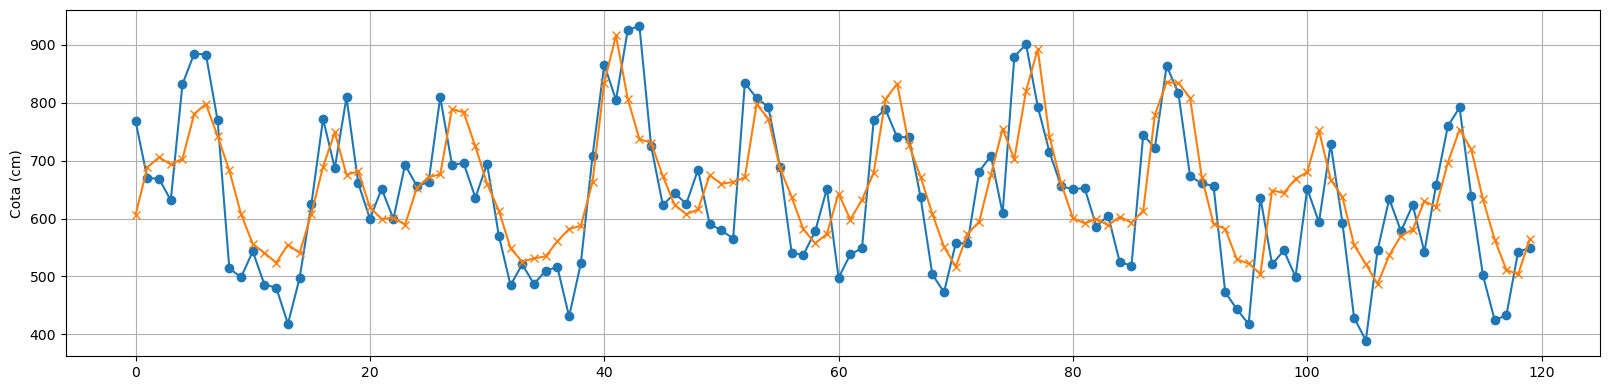

In [87]:
print(f"R² = {r2_score(y_test2, pred2_inv):.4f}")

plt.figure(figsize=(16, 4))
plt.plot(y_test2, marker='o', linestyle='-', label='Observado')
plt.plot(pred2_inv, marker='x', linestyle='-', label='Predito')
plt.tight_layout()
plt.ylabel('Cota (cm)')
plt.grid(True)
plt.show()

### Teste ML 3

In [88]:
X_a = X.drop(columns=['nino3', 'nino34'])
X_b = X.drop(columns=[0, 1, 2])

xa_scale = MinMaxScaler()
xb_scale = MinMaxScaler()
y_scale3 = MinMaxScaler()

X_train_a = X_a.values[3:treino.shape[0]-janela]
X_train_b = X_b.values[3:treino.shape[0]-janela]
y_train3 = y[3:treino.shape[0]-janela:]

X_test_a = X_a.values[treino.shape[0]-janela:]
X_test_b = X_b.values[treino.shape[0]-janela:]
y_test3 = y[treino.shape[0]-janela:]

X_train_a = xa_scale.fit_transform(X_train_a)
X_test_a = xa_scale.transform(X_test_a)

X_train_b = xb_scale.fit_transform(X_train_b)
X_test_b = xb_scale.transform(X_test_b)

y_train3 = y_scale3.fit_transform(y_train3)

In [1]:
# LSTM
# input_A = keras.layers.Input((janela, 1))
# lstm_layer = keras.layers.LSTM(30)(input_A)

# # MLP
# input_B = keras.layers.Input(shape=(X_train_b.shape[1],))
# dense1 = keras.layers.Dense(30)(input_B)
# dense2 = keras.layers.Dense(30)(dense1)

# # Concat
# concat = keras.layers.Concatenate()([lstm_layer, dense2])

# # Saída
# output = keras.layers.Dense(1)(concat)

# model = keras.Model(inputs=[input_A, input_B], outputs=[output])

# model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

lstm_mlp = ann.build_model_lstm_mlp(30, janela, (30, 30), X_train_b.shape[1])

lstm_mlp.fit((X_train_a, X_train_b), y_train3, epochs=250, callbacks=early_stop)

NameError: name 'ann' is not defined

In [ ]:
pred3 = model.predict((X_test_a, X_test_b))
pred3_inv = y_scale3.inverse_transform(pred3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


R² = 0.5753


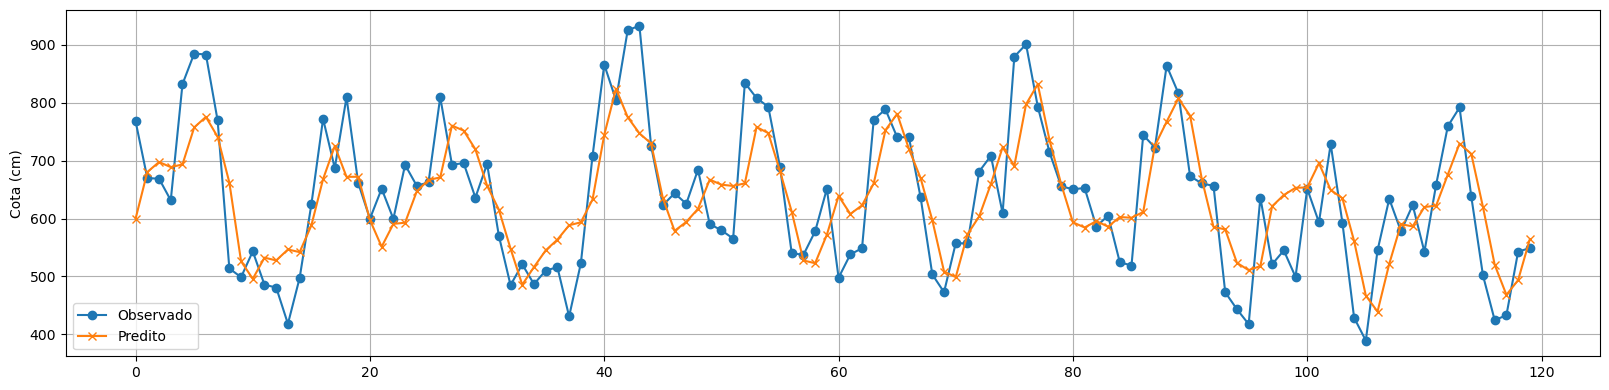

In [ ]:
print(f"R² = {r2_score(y_test3, pred3_inv):.4f}")

plt.figure(figsize=(16, 4))
plt.plot(y_test3, marker='o', linestyle='-', label='Observado')
plt.plot(pred3_inv, marker='x', linestyle='-', label='Predito')
plt.legend(loc='lower left')
plt.tight_layout()
plt.ylabel('Cota (cm)')
plt.grid(True)
plt.show()